## Building a Spam Filter using the Multinomial Naive Bayes Theorem

In this project, we'll use the Multinomial Naive Bayes Theorem to construct a function that can classify spam and non-spam (referred to below as 'ham') messages.  Our goal is to build a filter that can detect spam messages with 80% accuracy or greater.

### Overview

   In simplest terms, we want to build a function that takes a text message, and can classify that text message as either 'spam' or 'ham'. Behind the scenes, the function uses the words in the message to calculate two values: the probability the message is spam and the probability the message is non-spam. To calculate the spam probability for the message, we split the message into its individual words, then have the function reference dictionaries that contain the probabilities of spam / non-spam for each given  word. We use a dataset of known spam and non-spam messages to find the words that are more common in spam messages. We then use the Multinomial Naive Bayes formula to calculate the probability of spam given the message (as the sum of its words). If the probability of spam is higher than the probability of non-spam, the function will classify the message as spam and vice versa. 


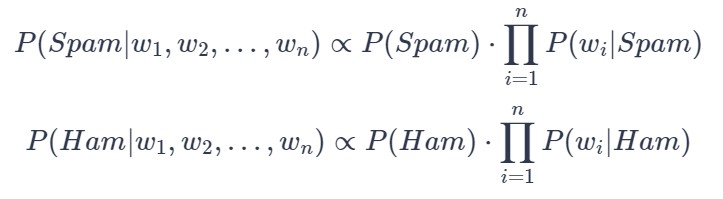

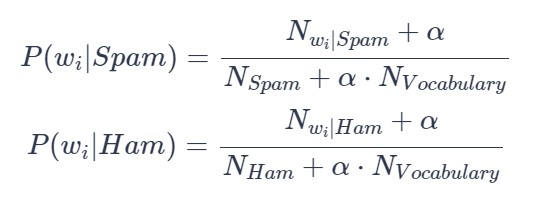

The formulas above represent the Multinomial Naive Bayes algorithm, we'll use a dataset to gather the information needed to perform our calculations

### Data

The dataset we'll be using to train and test our spam filter is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The dataset is a composite of messages sourced from the Grumbletext website, and research projects from a few universities. The dataset contains two columns:

- `Label` : the correct classification of spam or ham
- `SMS` : the text message

We'll begin by familiarizing ourselves with the dataset below 

In [8]:
import pandas as pd

spam=pd.read_csv("C:/Users/peted/Downloads/SMSSpamCollection", sep='\t', header=None,
                 names=['Label', 'SMS'])


In [9]:
spam.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [12]:
spam['Label'].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

### Testing and training data

The next step is to separate the primar dataset into testing and training data. Our training set will account for 80% of the data, and the remaining 20% will be used for testing. We shuffle the messages to introduce randomness before we split the data.

In [13]:
#creating a new dataset with suffled rows
ran_spam=spam.sample(frac=1,random_state=1)
ran_spam.head()

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [15]:
#using a reference index to allocate 80/20 split
cutoff_index=int(len(ran_spam)*.8)

train=ran_spam[:cutoff_index].reset_index(drop=True)
test=ran_spam[cutoff_index:].reset_index(drop=True)

Let's check whether our training and testing data has a similar ratio of spam to non-spam messages

In [16]:
rundown=pd.DataFrame()
rundown['train']=train['Label'].value_counts(normalize=True)
rundown['test']=test['Label'].value_counts(normalize=True)
rundown['all_data']=spam['Label'].value_counts(normalize=True)
rundown

,train,test,all_data
ham,0.86538,0.868161,0.865937
spam,0.13462,0.131839,0.134063


Great, it looks like there is a similar spam makeup of roughly 13% accross all of our training and test data

### Cleaning text data

Before we move on, we need to do some data cleaning to remove non-word characters from the messages in `SMS` column in our training set.

In [17]:
train['SMS'].head()

0                         Yep, by the pretty sculpture
1        Yes, princess. Are you going to make me moan?
2                           Welp apparently he retired
3                                              Havent.
4    I forgot 2 ask ü all smth.. There's a card on ...
Name: SMS, dtype: object

In [21]:
#using regex to catch non-word characters, replacing them with a single space
train['SMS']=train['SMS'].str.replace(r'\W', ' ', regex=True).str.lower()
train['SMS'].head()

0                         yep  by the pretty sculpture
1        yes  princess  are you going to make me moan 
2                           welp apparently he retired
3                                              havent 
4    i forgot 2 ask ü all smth   there s a card on ...
Name: SMS, dtype: object

In order to do our calculations later, we need to create a master vocabulary list containing each unique word used in the messages we have.

In [22]:
#transforming single sms strings to lists containing each word in sms
train['SMS']=train['SMS'].str.split()
train['SMS'].head()

0                    [yep, by, the, pretty, sculpture]
1    [yes, princess, are, you, going, to, make, me,...
2                      [welp, apparently, he, retired]
3                                             [havent]
4    [i, forgot, 2, ask, ü, all, smth, there, s, a,...
Name: SMS, dtype: object

In [23]:
#creating empty list to store all words
vocabulary=[]

#appending each word from each sms message to vocabulary
for row in train['SMS']:
    for word in row:
        vocabulary.append(str(word))

#dropping duplicates
vocabulary=list(set(vocabulary))
print(len(vocabulary))

7782


It looks like our vocabulary list contains 7782 unique words.

### Calculating constant values

Now that our data is cleaned, we can work on calculating the probability of spam and non-spam for each word in our vocabulary list. To do that, we need to build a dataframe that contains both the classification (spam or ham) and the frequency count of the words contained in the message. Below is a depiction of what we're trying to do:

![figure 2](https://dq-content.s3.amazonaws.com/433/cpgp_dataset_3.png)

This will help us find the words that are more frequently used in spam texts. We can then calculate the probabilities of spam and non-spam for each given word.

In [24]:
#creating a dictionary with each unique word as a key with values of 0
word_counts_per_sms={unique_word: [0]*len(train['SMS']) for unique_word in vocabulary}

#iterating over the SMS column training data to cacluate the frequency of each word in each message
for index, sms in enumerate(train['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

#converting the dictionary to a dataframe, adding the classification and original SMS from the train dataframe
word_counts_per_sms=pd.DataFrame(word_counts_per_sms)
train1=pd.concat([train, word_counts_per_sms], axis=1)

Now, we calculate the constants for the Multinomial Naive Bayes formula for later reference, listed below:

- `p_spam` : the probability a new message is spam
- `p_ham` : the probability a new message is non-spam
- `n_spam` : the number of words contained in all spam messages
- `n_ham` : the number of words contained in all non-spam messages
- `n_vocabulary` : the number of unique words
- `alpha` : a constant used for [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)

In [25]:
p_spam=train['Label'].value_counts(normalize=True)['spam']
p_ham=train['Label'].value_counts(normalize=True)['ham']

n_spam=train1[train1['Label']=='spam']
n_spam=n_spam[vocabulary].sum().sum()

n_ham=train1[train1['Label']=='ham']
n_ham=n_ham[vocabulary].sum().sum()

n_vocabulary=len(vocabulary)

alpha=1

In [26]:
stats=pd.DataFrame()
stats=stats.append([p_spam,p_ham,n_spam,n_ham,n_vocabulary,alpha])
stats.index=['p_spam','p_ham','n_spam','n_ham','n_vocabulary','alpha']
stats.columns=['value']
print('these are our constant values for the Naive Bayes Theorem:')
stats

these are our constant values for the Naive Bayes Theorem:


,value
p_spam,0.13462
p_ham,0.86538
n_spam,15190.00000
n_ham,57233.00000
n_vocabulary,7782.00000
alpha,1.00000


### Creating reference dictionaries

Now we have our constant values calculated, we're one step closer to building our spam filter. As mentioned before, we want to create a function that can take a text message, and return two values: the probability of spam given a message, and the probability of non-spam given a message. Mathematically, the formulas below describes the roadmap to get these values. Note we already have the overall probability of spam and the overall probability of ham calculated above

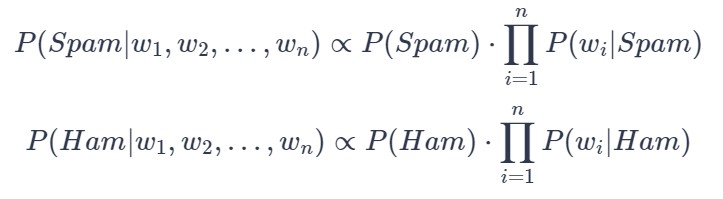

What we're currently missing are the probabilities of unique words given a message is spam or non-spam. The next step is to use the constant values from above to create reference dictionaries that contain these missing values. We can calculate the values according to the formulas below:

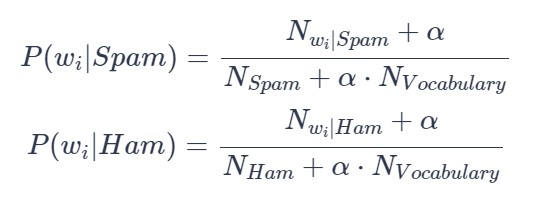

We have all the information we need to calculate these values, so the next step is to create reference dictionaries for our function.

In [27]:
#Creating dictionaries containing unique words as keys and probability values of 0, for now
pw_ham={unique_word:0 for unique_word in vocabulary}
pw_spam={unique_word:0 for unique_word in vocabulary}

#separating our training data into dataframes that contain only ham / spam messages
ham=train1[train1['Label']=='ham']
spam=train1[train1['Label']=='spam']

In [29]:
#populating pw_ham and pw_spam dictionaries with the values of P(word | spam/ham)
#we use the formula depicted in the second figure above
for word in vocabulary:
    pham_gword=(ham[word].sum() + alpha)/(n_ham+(alpha*n_vocabulary))
    pw_ham[word]=pham_gword
    
    pspam_gword=(spam[word].sum() + alpha)/(n_spam+(alpha*n_vocabulary))
    pw_spam[word]=pspam_gword

### Building the function

We now have our reference dictionaries populated with probabilities for each word given spam or non-spam. The next step is to create the `classify` function that can take a new text message and return a classification based off of the training data.

In [30]:
import re

def classify(sms):
#removing non-word characters from the new message, converting to lowercase, and splitting the message into a list of words
    message=re.sub('\W', ' ', sms)
    message=message.lower().split()
#iterating through all words contained in the messasge
#if word is in our vocabulary, reference the dictionary, and add to the cumulative product    
    h=1
    s=1
    for word in message:
        if word in set(vocabulary):
            h*=pw_ham[word]
            s*=pw_spam[word]
#using cumulative product to calculate final probability of spam and non-spam, given the words in the message   
    p_ham_given_message=h*p_ham
    p_spam_given_message=s*p_spam
#comparing probabilites, classify based on which probability is higher    
    if p_ham_given_message>p_spam_given_message:
        return 'ham'
    elif p_ham_given_message<p_spam_given_message:
        return 'spam'
    else:
        return 'need help'

In [31]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

'spam'

In [32]:
classify("Sounds good, Tom, then see u there")

'ham'

In [33]:
classify('Alert! Your cars extended warrenty is expiring soon, follow this link to extend for free')

'spam'

### Measuring the accuracy of our spam filter

Now we have our function, let's use the test data to measure the accuracy.

In [34]:
#applying our function to texts in test data, creating new column with the predictions
test['prediction']=test['SMS'].apply(classify)
test.head()

,Label,SMS,prediction
0,ham,Wherre's my boytoy ? :-(,ham
1,ham,Later i guess. I needa do mcat study too.,ham
2,ham,But i haf enuff space got like 4 mb...,ham
3,spam,Had your mobile 10 mths? Update to latest Oran...,spam
4,ham,All sounds good. Fingers . Makes it difficult ...,ham


In [35]:
#iterating through the rows in test data, comparing known classification and prediction
correct=0
total=len(test)

for row in test.iterrows():
    row=row[1]
    if row['Label']==row['prediction']:
        correct+=1
        
accuracy=correct/total
print('Our filter detected spam with', round((accuracy*100),2),'% accuracy')

Our filter detected spam with 98.74 % accuracy


### Conclusion

We managed to build a spam filter that far surpassed our goal of 80% accuracy! Out of curiosity, let's look at the misclassifications to see if we can determine what went wrong.

In [48]:
mistakes=test[test['Label']!=test['prediction']].copy()
mistakes.head()

,Label,SMS,prediction
115,spam,Not heard from U4 a while. Call me now am here...,ham
136,spam,More people are dogging in your area now. Call...,ham
153,ham,Unlimited texts. Limited minutes.,spam
160,ham,26th OF JULY,spam
285,ham,Nokia phone is lovly..,spam


Out of these first 5 mistakes, the first two were classified as 'ham' when they were really 'spam'. Let's look closer to see if we can see a pattern in these messages. Apologies for the explicit nature of these messages

In [51]:
print(mistakes.iloc[0]['SMS'])

Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net


In this case, the spam is trying to 'pose' as a real person, which is likely the reason it slipped passed our filter.

In [52]:
print(mistakes.iloc[1]['SMS'])

More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB


In this case, I imagine none of the individual words are 'spam-like' enough for it to have flagged the spam filter. Additionally, the accuracy of the filter would likely go up if it could detect things like numbers, hyperlinks, and codes. However, when training, it is unlikely for these codes to be repeated between different spam messages, so the spammyness of these kinds of words are unaccounted for in our reference dictionaries. 

In [53]:
print(mistakes.iloc[2:5]['SMS'])

153    Unlimited texts. Limited minutes.
160                         26th OF JULY
285               Nokia phone is lovly..
Name: SMS, dtype: object


These messages had the opposite problem as the first two, they were classified as spam when they were acutally ham. This is likely due to the relatively few words contained within the messages. The less information the function has to work with, the likelyhood of error goes up.

Overall, our spam filter is highly accurate in the context of the data we have to work with. It's worth noting that filters built with the Naive Bayes algorithm require relatively low computing power, since a lot of the values are calculated beforehand. Rather than calculating probabilities for each new message, the function simply references values are already stored in a dictionary. However, I imagine in the real-world spammers are constantly trying to revise their strategy to bypass these filters. 